In [35]:
import pyspark
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

In [2]:
pd.set_option('display.max_rows',100)

# Creation of your context

### set up a context

In [3]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

# Preparation of data (get it into parquet)

### Connect to S3

In [4]:
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'sk5be/Iris.csv'
data_location = 's3://{}/{}'.format(bucket, data_key) #data path
pddf = pd.read_csv(data_location)

### Data processing in pddf

In [5]:
def categorical_to_numeric(x):
    if x == "setosa":
        return 0
    if x == "versicolor":
        return 1
    if x == "virginica":
        return 2

In [6]:
pddf.Species = pddf.Species.apply(categorical_to_numeric)
pddf = pddf.loc[pddf.Species != 2]

### This is spark data frame imported from panda's dataframe. (This won't work for big files since this way uses memory) 

In [7]:
df = sqlc.createDataFrame(pddf)

In [8]:
df

DataFrame[SepalLength: double, SepalWidth: double, PetalLength: double, PetalWidth: double, Species: bigint]

### Write parquet to s3

In [9]:
#This code would have AnalysisException error since the path is already created and this code re-runs along with others. 
parquetPath = '/home/ec2-user/SageMaker/sk5be/parquet_Irisfinal'
df.write.parquet(parquetPath)

In [10]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
for f in files:
    #print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "sample_data/pqt/"+f)


### Write to spark dataframe from parquet 

In [11]:
df = sqlc.read.parquet(parquetPath)

In [12]:
df

DataFrame[SepalLength: double, SepalWidth: double, PetalLength: double, PetalWidth: double, Species: bigint]

# MLlib based analysis

### VECTORIZATION - spark special sauce

In [13]:
from pyspark.ml.feature import VectorAssembler

In [14]:
assembler = VectorAssembler(
    inputCols=["SepalLength", "SepalWidth", "PetalLength","PetalWidth"],
    outputCol="features")
output = assembler.transform(df)

In [15]:
output = output.drop("SepalLength", "SepalWidth", "PetalLength","PetalWidth")

In [16]:
output.show(truncate=False)

+-------+-----------------+
|Species|features         |
+-------+-----------------+
|0      |[5.1,3.5,1.4,0.2]|
|0      |[4.9,3.0,1.4,0.2]|
|0      |[4.7,3.2,1.3,0.2]|
|0      |[4.6,3.1,1.5,0.2]|
|0      |[5.0,3.6,1.4,0.2]|
|0      |[5.4,3.9,1.7,0.4]|
|0      |[4.6,3.4,1.4,0.3]|
|0      |[5.0,3.4,1.5,0.2]|
|0      |[4.4,2.9,1.4,0.2]|
|0      |[4.9,3.1,1.5,0.1]|
|0      |[5.4,3.7,1.5,0.2]|
|0      |[4.8,3.4,1.6,0.2]|
|0      |[4.8,3.0,1.4,0.1]|
|0      |[4.3,3.0,1.1,0.1]|
|0      |[5.8,4.0,1.2,0.2]|
|0      |[5.7,4.4,1.5,0.4]|
|0      |[5.4,3.9,1.3,0.4]|
|0      |[5.1,3.5,1.4,0.3]|
|0      |[5.7,3.8,1.7,0.3]|
|0      |[5.1,3.8,1.5,0.3]|
+-------+-----------------+
only showing top 20 rows



### Create train/test sets

In [17]:
# create train/test sets
seed = 42
(testDF, trainingDF) = output.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 78, test set N = 22


In [18]:
# rename to make ML engine happy
trainingDF = trainingDF.withColumnRenamed("Species", "label") #here, label and features are syntax!
testDF = testDF.withColumnRenamed("Species", "label")

# 1.Logistic regression

### 1.Train a model

In [19]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
# Fit the model
lrModel = lr.fit(trainingDF)

In [20]:
# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(lrModel.coefficientMatrix))
print("Intercept: " + str(lrModel.interceptVector))

Coefficients: 
DenseMatrix([[ 0.        , -0.39488638,  0.26512287,  0.75657199]])

Intercept: [0.050994195348395]


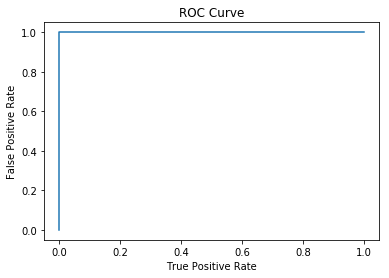

In [22]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### 2.Predict

In [23]:
predictions = lrModel.transform(testDF)

In [24]:
predictions.show()

+-----+-----------------+--------------------+--------------------+----------+
|label|         features|       rawPrediction|         probability|prediction|
+-----+-----------------+--------------------+--------------------+----------+
|    0|[4.6,3.2,1.4,0.2]|[0.69015580953523...|[0.66600158646240...|       0.0|
|    0|[4.6,3.4,1.4,0.3]|[0.69347588664236...|[0.66673970846055...|       0.0|
|    0|[4.7,3.2,1.6,0.2]|[0.63713123648740...|[0.65410468511469...|       0.0|
|    0|[4.8,3.0,1.4,0.1]|[0.68683573242810...|[0.66526265040207...|       0.0|
|    0|[4.9,3.1,1.5,0.2]|[0.62415488508259...|[0.65116292153813...|       0.0|
|    0|[4.9,3.6,1.4,0.1]|[0.92376756000043...|[0.71580914966593...|       0.0|
|    0|[5.0,3.0,1.6,0.2]|[0.55815396062996...|[0.63602529489165...|       0.0|
|    0|[5.0,3.4,1.6,0.4]|[0.56479411484421...|[0.63756107865569...|       0.0|
|    0|[5.2,3.4,1.4,0.2]|[0.76913308539267...|[0.68333333286913...|       0.0|
|    0|[5.2,4.1,1.5,0.1]|[1.09469846312011...|[0.749

### 3.Model Evaluation 

In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
# Evalues with "areaUnderROC" as a metric
evaluator.getMetricName()

'areaUnderROC'

In [26]:
# Evalues with "areaUnderROC" as a metric
evaluator.evaluate(predictions)

1.0

# Decision Trees

### 1. Train a model

In [27]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=3)

# Train model with Training Data
dtModel = dt.fit(trainingDF)

In [28]:
display(dtModel)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_464286756702b1815be0) of depth 1 with 3 nodes

In [29]:
print("numNodes = ", dtModel.numNodes)
print("depth = ", dtModel.depth)

numNodes =  3
depth =  1


### 2.Predict

In [31]:
predictions = dtModel.transform(testDF)

In [32]:
predictions.show()

+-----+-----------------+-------------+-----------+----------+
|label|         features|rawPrediction|probability|prediction|
+-----+-----------------+-------------+-----------+----------+
|    0|[4.6,3.2,1.4,0.2]|   [35.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[4.6,3.4,1.4,0.3]|   [35.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[4.7,3.2,1.6,0.2]|   [35.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[4.8,3.0,1.4,0.1]|   [35.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[4.9,3.1,1.5,0.2]|   [35.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[4.9,3.6,1.4,0.1]|   [35.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[5.0,3.0,1.6,0.2]|   [35.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[5.0,3.4,1.6,0.4]|   [35.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[5.2,3.4,1.4,0.2]|   [35.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[5.2,4.1,1.5,0.1]|   [35.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[5.4,3.9,1.3,0.4]|   [35.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[5.5,3.5,1.3,0.2]|   [35.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[5.5,4.2,1.4,0.2]|   [35.0,0.0]|  [1.0,0.0]|    

### 3.Model Evalution

In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

1.0

# Addtional Visualization

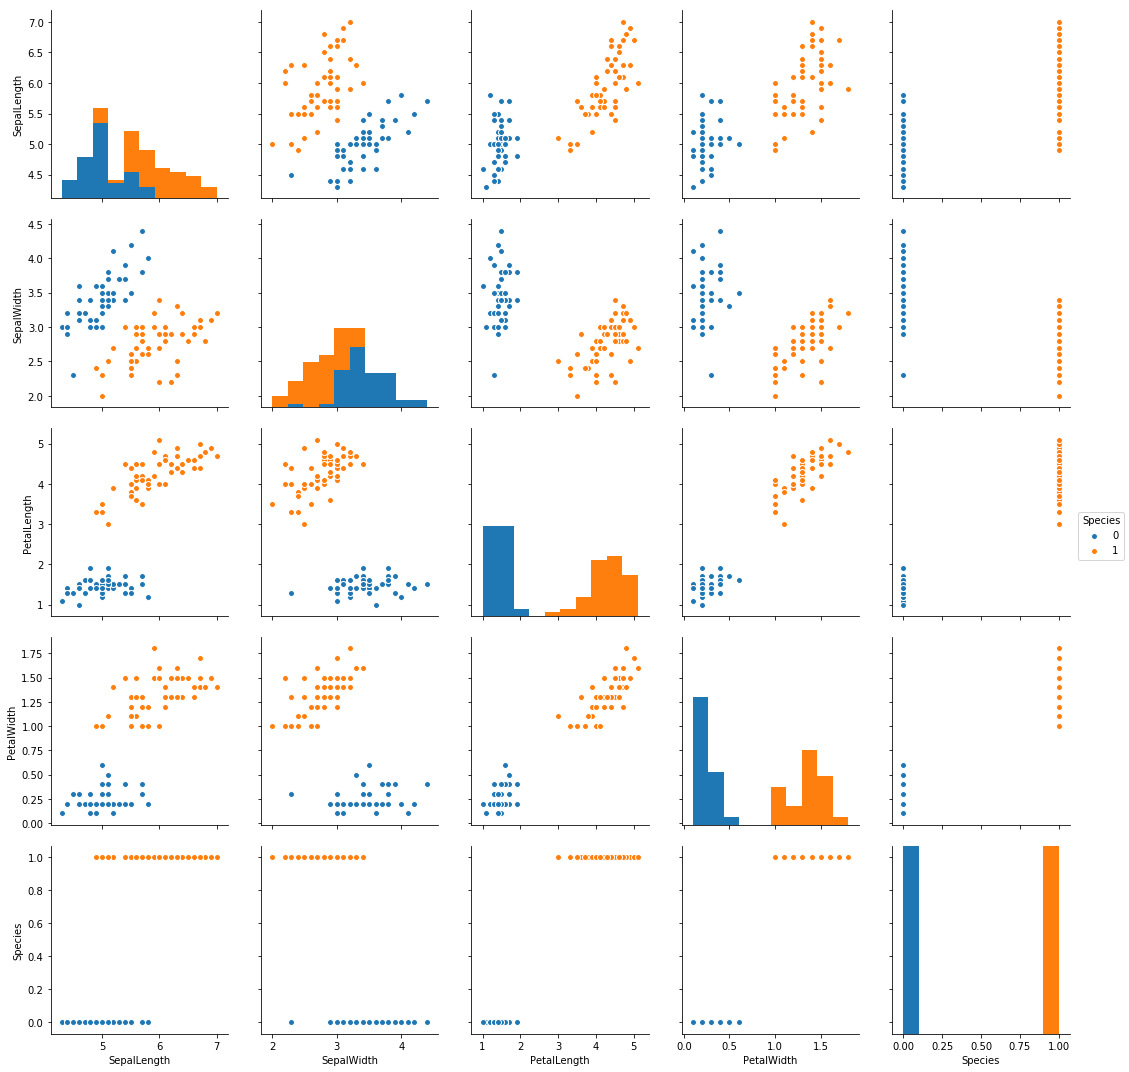

In [36]:
sns.pairplot(pddf, hue="Species", size=3)
plt.show()